Keep all the imports at the beginning of the notebook.

In [1]:
import os
# os.chdir("/content/drive/MyDrive/Colab Notebooks/02805 Social Graphs")
import re
import statistics as st
import typing as t
from tqdm import tqdm

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import fa2

import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns

# Basic Stats

In [2]:
class Character:
    """Class containing information about marvel/dc character"""
    
    def __init__(self, name: str, universe: str, data: str):
        self.name = name
        self.universe = universe
        self.data = data
        self.connections = None
        self.n_words = 0
    
    def inspect_data(self, valid_names: t.List[str]):
        """Inspect data looking for connections and number of words"""

        re_wikilink = re.compile(r"(?:\[\[)(.*?)(?:\]\])")
        self.connections = set(filter(lambda name: name in valid_names, re_wikilink.findall(self.data)))
        self.n_words = len(re.findall(r"\b\w+\b", self.data))
    
    def __str__(self):
        return str(self.__dict__)
    
class Characters:
    """A wrapper class for storing information about marvel/dc characters"""

    def __init__(self, characters: t.List[Character]):
        self.characters = characters
    
    @classmethod
    def from_dirs(cls, *args):
        characters = []
        char_names = []
        paths = []

        for dir in args:
            if not os.path.isdir(dir):
                print(f"{dir} is not a directory, skipping")
                continue
            for char_file in os.listdir(dir):
                if not os.path.isfile(os.path.join(dir, char_file)):
                    print(f"{path} is not a file, skipping")
                    continue
                paths.append((dir, char_file))
                char_names.append(char_file.replace(".txt", ""))

        print("reading character files")
        for char_name, path in tqdm(zip(char_names, paths), total=len(paths)):
                try:
                    with open(os.path.join(*path), "r", encoding="utf-8") as rfile:
                        char = Character(
                            name = char_name,
                            universe = path[0],
                            data = rfile.read(),
                        )
                        char.inspect_data(char_names)
                        characters.append(char)
                except IOError:
                    print(f"something went wrong when reading {os.path.join(*path)}")
        return cls(characters)

    def get(self, name: str, default=None) -> Character:
        """
        Get a character if present, otherwise default value.

        Parameters
        ----------
        name:
            Character name
        default: [None]
            Default return value if character not found
        
        Returns
        -------
        [Character|default]
        """

        for char in self.characters:
            if char.name == name:
                return char
        return default
    
    @property
    def names(self):
        return [char.name for char in self.characters]
    
    @property
    def marvel(self):
        return [char for char in self.characters if char.universe == "marvel"]
    

    @property
    def dc(self):
        return [char for char in self.characters if char.universe == "dc"]

In [3]:
characters = Characters.from_dirs("marvel", "dc")

reading character files


100%|██████████| 2252/2252 [00:12<00:00, 176.30it/s]


Construct a DiGraph of marvel and DC connections

In [4]:
def calc_stats(graph_degrees: nx.Graph):
    """
    Calculate mean, median, mode, min and max of given graph degrees
    
    Returns
    -------
    Namespace
        Namespace with statistics
    """

    class Namespace:
        def __init__(self, **kwargs):
            self.__dict__.update(**kwargs)
        
        def __str__(self):
            return str(self.__dict__)

    degrees = [elem[1] for elem in sorted(graph_degrees, key=lambda x: x[1], reverse=True)]
    return Namespace(
        mean=st.mean(degrees),
        median=st.median(degrees),
        mode=st.mode(degrees),
        min=min(degrees),
        max=max(degrees),
    )

def print_header(title: str):
    """Prints pretty header"""
    print("="*20 + f" {title} " + "="*20 + "\n")

In [5]:
Universe = nx.DiGraph()
for character in characters.characters:
    Universe.add_node(character.name, universe=character.universe, n_words=character.n_words)
    for connection in character.connections:
        if connection not in Universe:
            mate = characters.get(connection)
            if mate and mate != character.name:
                Universe.add_node(
                    connection,
                    universe=mate.name,
                    n_words=mate.n_words
                )
        Universe.add_edge(character.name, connection)

In [6]:
print(f"Number of nodes: {len(Universe.nodes)}")
print(f"Number of links: {len(Universe.edges)}")

Number of nodes: 2252
Number of links: 13911


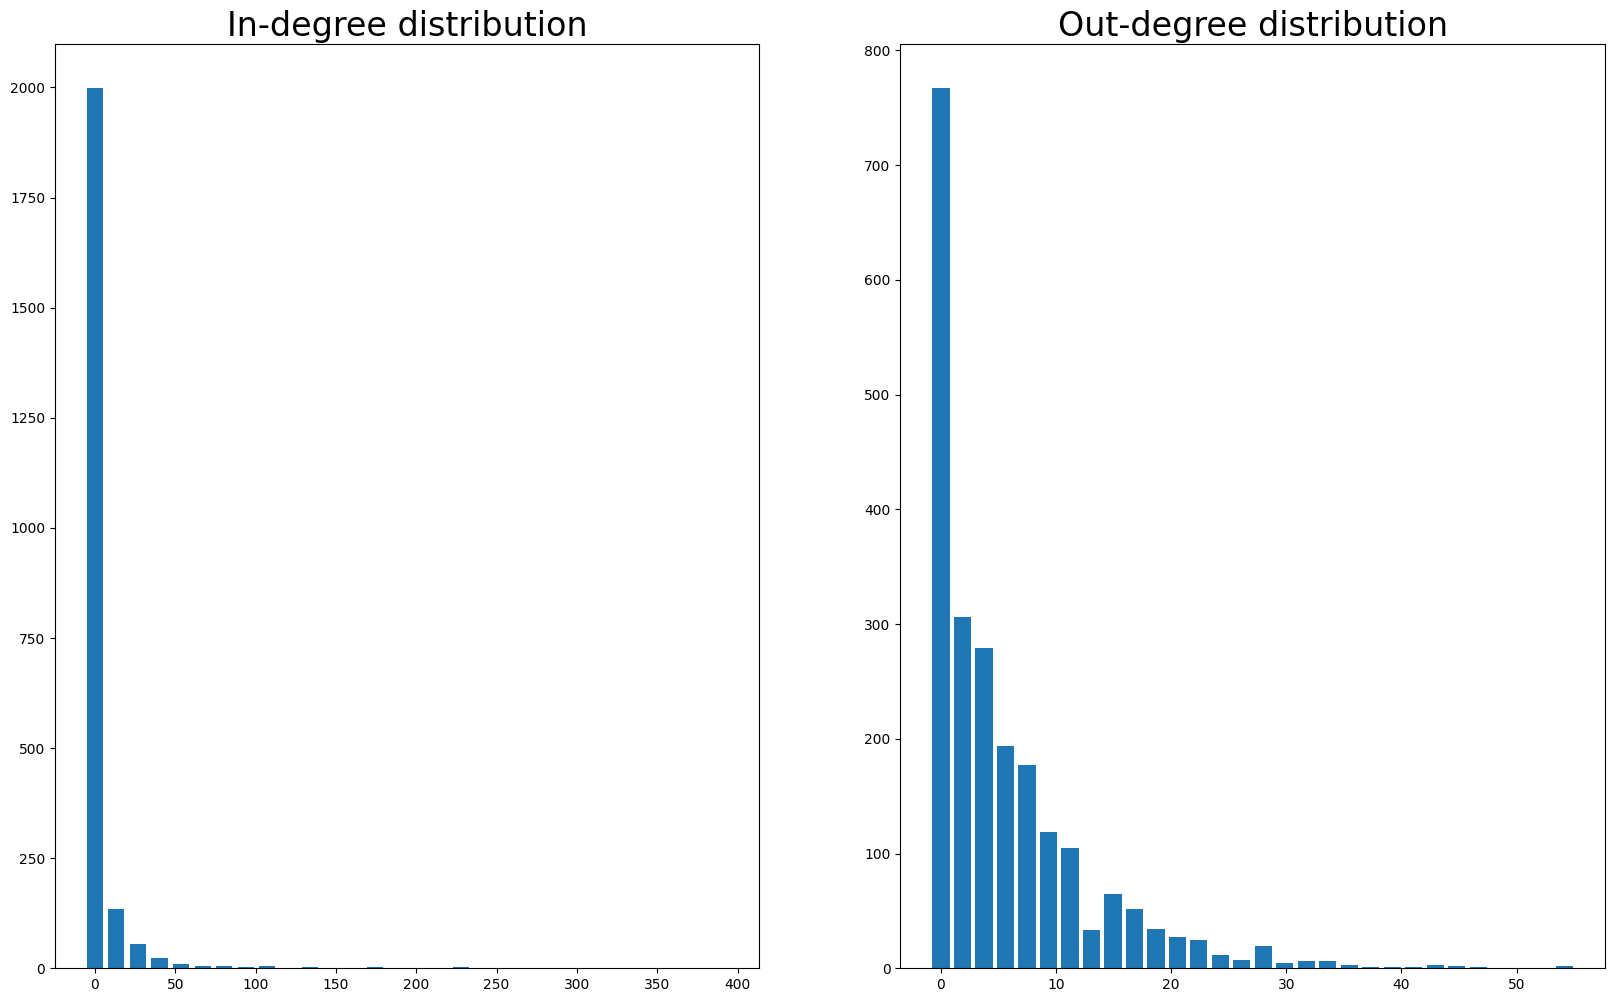

In [7]:
in_degrees = [d for _, d in Universe.in_degree()]
out_degrees = [d for _, d in Universe.out_degree()]

in_hist, in_bins = np.histogram(in_degrees, 30)
out_hist, out_bins = np.histogram(out_degrees, 30)

# TODO: make plots more attractive
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].bar(in_bins[:-1], in_hist, width=10)
ax[0].set_title("In-degree distribution", size=24)
ax[1].bar(out_bins[:-1], out_hist, width=1.5)
ax[1].set_title("Out-degree distribution", size=24)
plt.show()

In [8]:
print_header("Universe stats")
in_stats = calc_stats(Universe.in_degree())
out_stats = calc_stats(Universe.out_degree())
print(f"In degree: {in_stats}")
print(f"Out degree: {out_stats}")

==================== Universe stats ====================

In degree: {'mean': 6.177175843694494, 'median': 0.0, 'mode': 0, 'min': 0, 'max': 402}
Out degree: {'mean': 6.177175843694494, 'median': 4.0, 'mode': 0, 'min': 0, 'max': 56}


In [9]:
YELLOW = "#fce700"
BLUE = "#00d7fc"
GRAY = "#000000"

largest_component = sorted(nx.weakly_connected_components(Universe), key=len, reverse=True)[0]
Undirected_universe_lc = Universe.subgraph(largest_component).to_undirected()
# set node colors
node_color = ["#e6253e" if Undirected_universe_lc.nodes[node]["universe"] == "marvel" else "#000000" for node in Undirected_universe_lc.nodes]
# set node size
node_size = [Undirected_universe_lc.degree(node)//3 for node in Undirected_universe_lc.nodes]
# edge color
edge_color = []
for node1, node2 in Undirected_universe_lc.edges():
    universe1 = Undirected_universe_lc.nodes[node1]["universe"]
    universe2 = Undirected_universe_lc.nodes[node2]["universe"]
    if universe1 == universe2:
        if universe1 == "marvel":
            edge_color.append(YELLOW)
        else:
            edge_color.append(BLUE)
    else:
        edge_color.append(GRAY)

positions = fa2.ForceAtlas2().forceatlas2_networkx_layout(Undirected_universe_lc, pos=None, iterations=2000)

100%|██████████| 2000/2000 [02:42<00:00, 12.33it/s]

BarnesHut Approximation  took  21.06  seconds
Repulsion forces  took  135.33  seconds
Gravitational forces  took  0.47  seconds
Attraction forces  took  0.75  seconds
AdjustSpeedAndApplyForces step  took  1.98  seconds


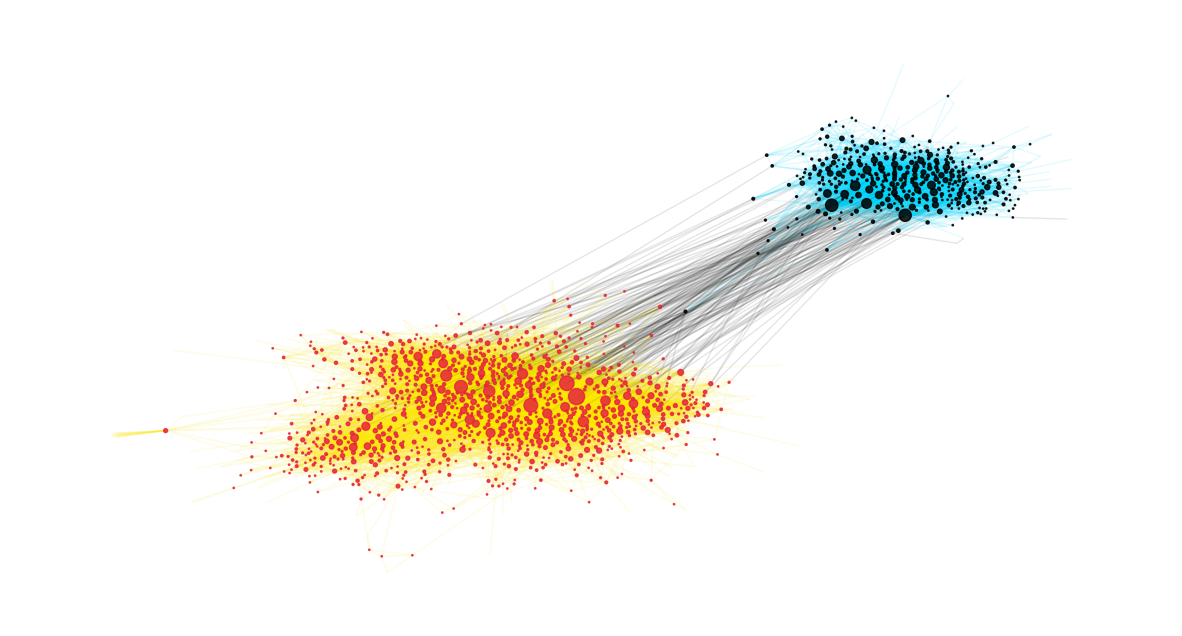

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
nx.draw_networkx_nodes(Undirected_universe_lc, positions, node_color=node_color, node_size=node_size, alpha=0.85, ax=ax)
nx.draw_networkx_edges(Undirected_universe_lc, positions, edge_color=edge_color, alpha=0.1, ax=ax)
ax.axis("off")
plt.show()

# Sentiment

In [11]:
# function to preprocess text into tokens
def preprocess_text(text):
     text = str(text).lower() 
     text = re.sub('[^a-zA-Z]+',' ', text).strip() 
     tokens = word_tokenize(text)
     tokens = [t for t in tokens if t not in stopwords.words('english')]    
     return tokens

# function to calculate sentiment for single text
def sentiment(text, wordlist):
    score = 0
    counter = 0
    for s in text:
        if s in wordlist.word.values:
            counter += 1
            score += wordlist[wordlist.word == s].happiness_average.values[0]
    # if the counter in 0 it mean that in this text we did not find words from wordlist
    if counter == 0:
        score = None
    else:
        score = score/counter
    return score

In [12]:
# load wordlist
wordlist = pd.read_csv('wordlist.txt', sep = '\t')

# # store sentiment for all character pages
# sentiment_score = []
# for character in characters.characters:
#     sentiment_score.append(sentiment(preprocess_text(character.data), wordlist))

In [13]:
# store sentiment together with character name
# sentiment_data = pd.DataFrame()
# sentiment_data['CharacterName'] = [characters.characters[i].name for i in range(len(characters.characters))]
# sentiment_data['Sentiment'] = sentiment_score
sentiment_data = pd.read_csv('sentiment_data.csv', sep = ',')
sentiment_data = sentiment_data.dropna()
sentiment_data.head(3)

,Unnamed: 0,CharacterName,Sentiment
0,0,3-D Man,5.694319
1,1,Abigail Brand,5.496650
2,2,Abner Jenkins,5.528284


In [14]:
mean_sentiment = sentiment_data.Sentiment.mean()
print(f'Average sentiment of all characters: {np.round(mean_sentiment, 2)}')
percentile_10 = sentiment_data.Sentiment.quantile(0.1)
print(f'10th percentile of all characters: {np.round(percentile_10, 2)}')
percentile_90 = sentiment_data.Sentiment.quantile(0.9)
print(f'90th percentile of all characters: {np.round(percentile_90, 2)}')

Average sentiment of all characters: 5.6
10th percentile of all characters: 5.41
90th percentile of all characters: 5.79


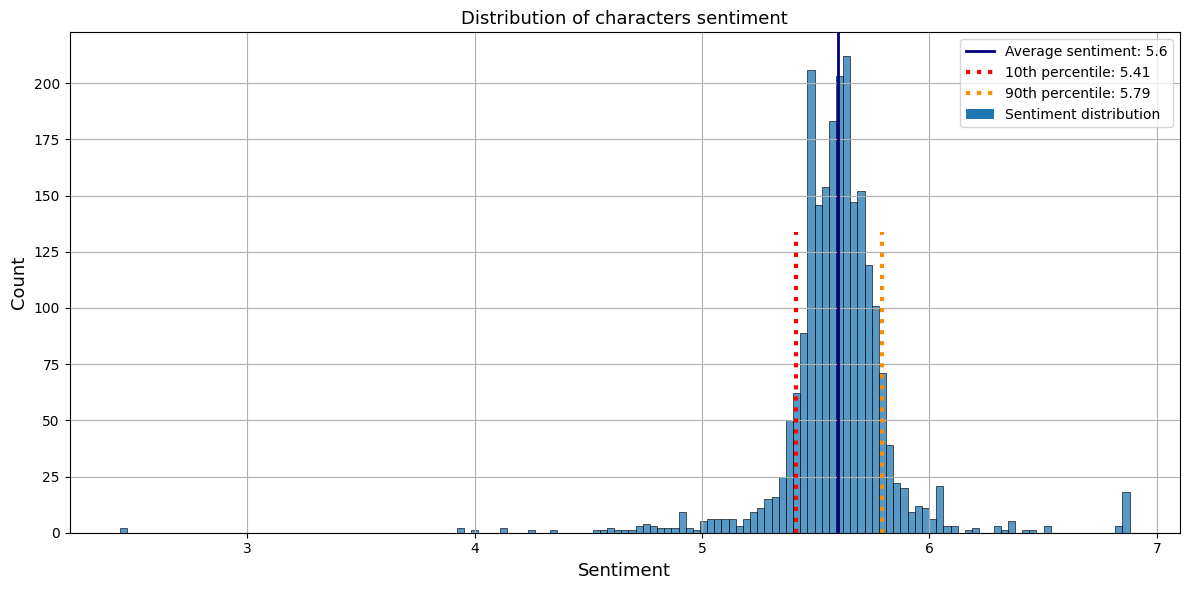

In [15]:
plt.figure(figsize = (12,6))
sns.histplot(sentiment_data.Sentiment);
plt.axvline(mean_sentiment, color = 'navy', linewidth = 2)
plt.xlabel('Sentiment', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.title('Distribution of characters sentiment', fontsize = 13)

plt.axvline(percentile_10, ymax = 0.6, linestyle = ":", linewidth = 3, color = 'red')
plt.axvline(percentile_90, ymax = 0.6, linestyle = ":", linewidth = 3, color = 'darkorange')

plt.legend([f'Average sentiment: {np.round(mean_sentiment, 2)}', f'10th percentile: {np.round(percentile_10, 2)}', f'90th percentile: {np.round(percentile_90, 2)}', 'Sentiment distribution'])
plt.grid()
plt.tight_layout()

In [16]:
# load data with good/bad characters
good_bad_characters = pd.read_csv('good_bad_characters.csv', sep = ',')
good_bad_characters = good_bad_characters.drop('CharacterName', axis = 1)
good_bad_characters.rename(columns={'WikiLink':'CharacterName'}, inplace = True)
good_bad_characters[['good', 'bad']] = good_bad_characters[['good', 'bad']].astype('bool')
good_bad_characters.head(3)

,CharacterName,universe,woman,man,good,bad
0,Abomination (character),Marvel,0,1,False,True
1,Absorbing Man,Marvel,0,1,False,True
2,Achebe (comics),Marvel,0,0,False,False


In [17]:
# leave only characters which are in both data frames
good_bad_characters = good_bad_characters[good_bad_characters.CharacterName.isin(sentiment_data.CharacterName.values)]
sentiment_data = sentiment_data[sentiment_data.CharacterName.isin(good_bad_characters.CharacterName.values)]
# merge data together
sentiment_data = sentiment_data.merge(good_bad_characters, on = 'CharacterName')

In [18]:
mean_sentiment_good = sentiment_data[sentiment_data.good].Sentiment.mean()
mean_sentiment_bad = sentiment_data[sentiment_data.bad].Sentiment.mean()
print(f'Average sentiment of good characters: {np.round(mean_sentiment_good, 2)}')
print(f'Average sentiment of bad characters: {np.round(mean_sentiment_bad, 2)}')

percentile_10_good = sentiment_data[sentiment_data.good].Sentiment.quantile(0.1)
percentile_10_bad = sentiment_data[sentiment_data.bad].Sentiment.quantile(0.1)
print(f'10th percentile of good characters: {np.round(percentile_10_good, 2)}')
print(f'10th percentile of bad characters: {np.round(percentile_10_bad, 2)}')

percentile_90_good = sentiment_data[sentiment_data.good].Sentiment.quantile(0.9)
percentile_90_bad = sentiment_data[sentiment_data.bad].Sentiment.quantile(0.9)
print(f'90th percentile of good characters: {np.round(percentile_90_good, 2)}')
print(f'90th percentile of bad characters: {np.round(percentile_90_bad, 2)}')

Average sentiment of good characters: 5.63
Average sentiment of bad characters: 5.55
10th percentile of good characters: 5.47
10th percentile of bad characters: 5.42
90th percentile of good characters: 5.78
90th percentile of bad characters: 5.71


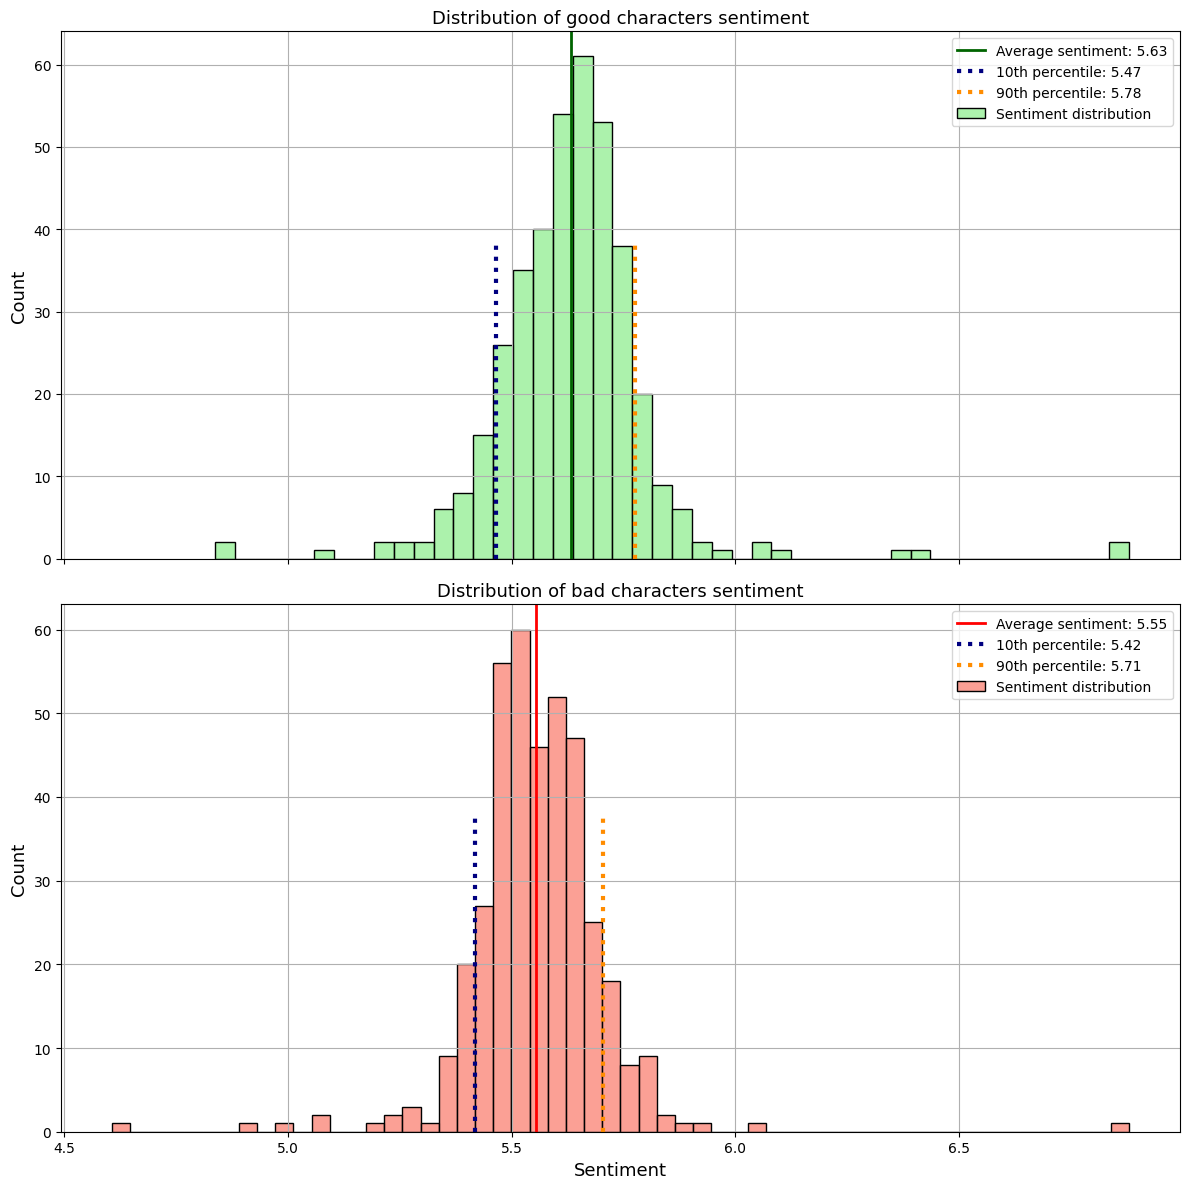

In [19]:
fig, ax = plt.subplots(2,1, figsize = (12,12), sharex = True)

sns.histplot(sentiment_data[sentiment_data.good].Sentiment, ax = ax[0], color = 'lightgreen');
ax[0].axvline(mean_sentiment_good, color = 'darkgreen', linewidth = 2)
ax[0].set_xlabel('Sentiment', fontsize = 13)
ax[0].set_ylabel('Count', fontsize = 13)
ax[0].set_title('Distribution of good characters sentiment', fontsize = 13)

ax[0].axvline(percentile_10_good, ymax = 0.6, linestyle = ":", linewidth = 3, color = 'navy')
ax[0].axvline(percentile_90_good, ymax = 0.6, linestyle = ":", linewidth = 3, color = 'darkorange')

ax[0].legend([f'Average sentiment: {np.round(mean_sentiment_good, 2)}', f'10th percentile: {np.round(percentile_10_good, 2)}', f'90th percentile: {np.round(percentile_90_good, 2)}', 'Sentiment distribution'])
ax[0].grid()

sns.histplot(sentiment_data[sentiment_data.bad].Sentiment, ax = ax[1], color = 'salmon');
ax[1].axvline(mean_sentiment_bad, color = 'red', linewidth = 2)
ax[1].set_xlabel('Sentiment', fontsize = 13)
ax[1].set_ylabel('Count', fontsize = 13)
ax[1].set_title('Distribution of bad characters sentiment', fontsize = 13)

ax[1].axvline(percentile_10_bad, ymax = 0.6, linestyle = ":", linewidth = 3, color = 'navy')
ax[1].axvline(percentile_90_bad, ymax = 0.6, linestyle = ":", linewidth = 3, color = 'darkorange')

ax[1].legend([f'Average sentiment: {np.round(mean_sentiment_bad, 2)}', f'10th percentile: {np.round(percentile_10_bad, 2)}', f'90th percentile: {np.round(percentile_90_bad, 2)}', 'Sentiment distribution'])
ax[1].grid()
plt.tight_layout()

## Permutation test

In [20]:
mean_sentiment_good_list = []
mean_sentiment_bad_list = []
for i in range(1000):
    good_characters = np.random.permutation(sentiment_data.good.values)
    mean_sentiment_good_list.append(sentiment_data[good_characters].Sentiment.mean())

    bad_characters = np.random.permutation(sentiment_data.bad.values)
    mean_sentiment_bad_list.append(sentiment_data[bad_characters].Sentiment.mean())
        

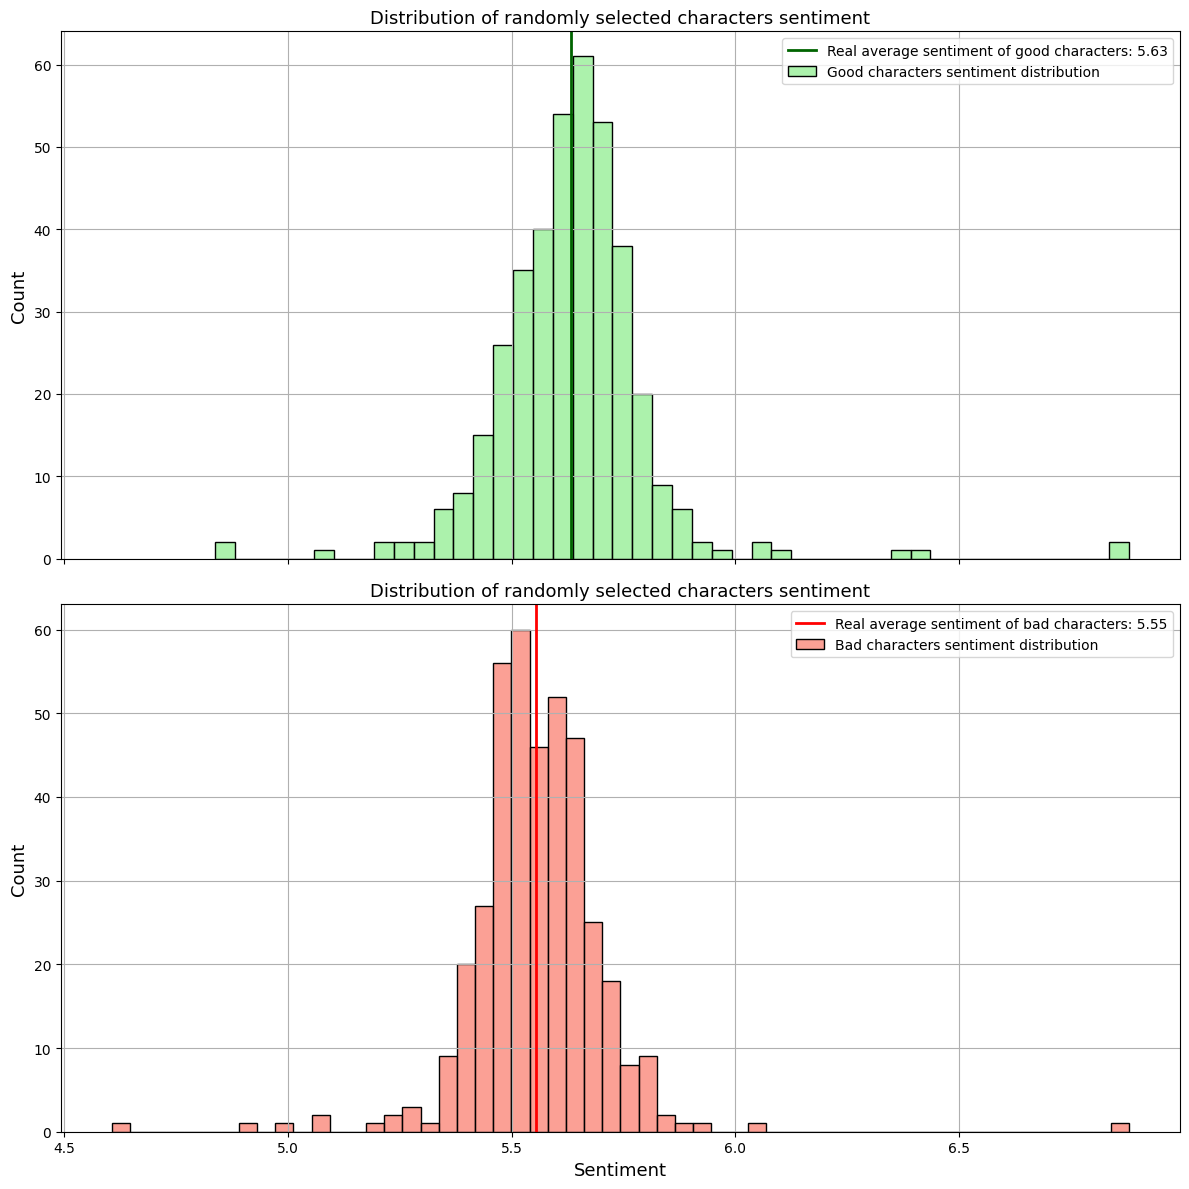

In [21]:
fig, ax = plt.subplots(2,1, figsize = (12,12), sharex = True)

sns.histplot(sentiment_data[sentiment_data.good].Sentiment, ax = ax[0], color = 'lightgreen');
ax[0].axvline(mean_sentiment_good, color = 'darkgreen', linewidth = 2)
ax[0].set_xlabel('Sentiment', fontsize = 13)
ax[0].set_ylabel('Count', fontsize = 13)
ax[0].set_title('Distribution of randomly selected characters sentiment', fontsize = 13)

ax[0].legend([f'Real average sentiment of good characters: {np.round(mean_sentiment_good, 2)}', 'Good characters sentiment distribution'])
ax[0].grid()


sns.histplot(sentiment_data[sentiment_data.bad].Sentiment, ax = ax[1], color = 'salmon');
ax[1].axvline(mean_sentiment_bad, color = 'red', linewidth = 2)
ax[1].set_xlabel('Sentiment', fontsize = 13)
ax[1].set_ylabel('Count', fontsize = 13)
ax[1].set_title('Distribution of randomly selected characters sentiment', fontsize = 13)

ax[1].legend([f'Real average sentiment of bad characters: {np.round(mean_sentiment_bad, 2)}', 'Bad characters sentiment distribution'])
ax[1].grid()
plt.tight_layout()